In [1]:
#@title IMPORT

import os
import pathlib

import tensorflow as tf

keras = tf.keras
from keras import layers
from keras.models import Sequential
from keras.applications.resnet_v2 import ResNet50V2
#from keras.applications.resnet import ResNet50

import matplotlib.pyplot as plt
import gdown
import zipfile

import time

In [8]:
#@title DATASET LOAD

DATASET_PATH = 'iris_id_64'

# load dataset from gdrive
if not os.path.exists(DATASET_PATH):
    os.makedirs(DATASET_PATH)
    print(f"MkDir {DATASET_PATH}")

    print('Загружаем датасет с диска')
    url_df = 'https://drive.google.com/file/d/16-_10SOqUilxy8ZR_7zK5HsdvQG8twuo/view?usp=sharing'

    gdown.download(url_df, quiet=False, use_cookies=False, fuzzy=True)

    zip_ds = 'dataset_iris_id_64.zip'

    with zipfile.ZipFile(zip_ds, 'r') as zip_ref:
        zip_ref.extractall(DATASET_PATH)

else:
    print('Найден локальный датасет')

train_path = f"{DATASET_PATH}/train"
# val_path = f"{DATASET_PATH}/val"
test_path = f"{DATASET_PATH}/test"

train_path = pathlib.Path(train_path)
# val_path = pathlib.Path(val_path)
test_path = pathlib.Path(test_path)

train_path_cnt =  len(list(train_path.glob('**/'))) - 1
train_path_files = len(list(train_path.glob('**/*.png')))

# val_path_cnt =  len(list(val_path.glob('**/'))) - 1
# val_path_files = len(list(val_path.glob('**/*.png')))

test_path_cnt =  len(list(test_path.glob('**/'))) - 1
test_path_files = len(list(test_path.glob('**/*.png')))

print(f'\n{train_path=}')
print(f"Найдено папок: {train_path_cnt}, файлов: {train_path_files}")

# print(f'\n{val_path=}')
# print(f"Найдено папок: {val_path_cnt}, файлов: {val_path_files}")

print(f'\n{test_path=}')
print(f"Найдено папок: {test_path_cnt}, файлов: {test_path_files}")

MkDir iris_id_64
Загружаем датасет с диска


Downloading...
From: https://drive.google.com/uc?id=16-_10SOqUilxy8ZR_7zK5HsdvQG8twuo
To: /content/dataset_iris_id_64.zip
100%|██████████| 179M/179M [00:00<00:00, 290MB/s]



train_path=PosixPath('iris_id_64/train')
Найдено папок: 64, файлов: 256

test_path=PosixPath('iris_id_64/test')
Найдено папок: 64, файлов: 128


In [9]:
#@title Sizes

batch_size = 32
img_height = 224
img_width = 224
val_split = 0.1

In [10]:
#@title train_ds preparing

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    label_mode='int',
    shuffle=True,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    crop_to_aspect_ratio=True,
    validation_split=val_split,
    subset="training"
)

Found 256 files belonging to 64 classes.
Using 231 files for training.
(32, 224, 224, 3)
(32,)


In [11]:
#@title val_ds preparing

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    label_mode='int',
    shuffle=True,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    crop_to_aspect_ratio=True,
    validation_split=val_split,
    subset="validation"
)

Found 256 files belonging to 64 classes.
Using 25 files for validation.


In [12]:
#@title test_ds preparing
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    label_mode='int',
    shuffle=True,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

Found 128 files belonging to 64 classes.


In [13]:
#@title classes
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"{num_classes=}")
print(f"{class_names=}")

num_classes=64
class_names=['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064']


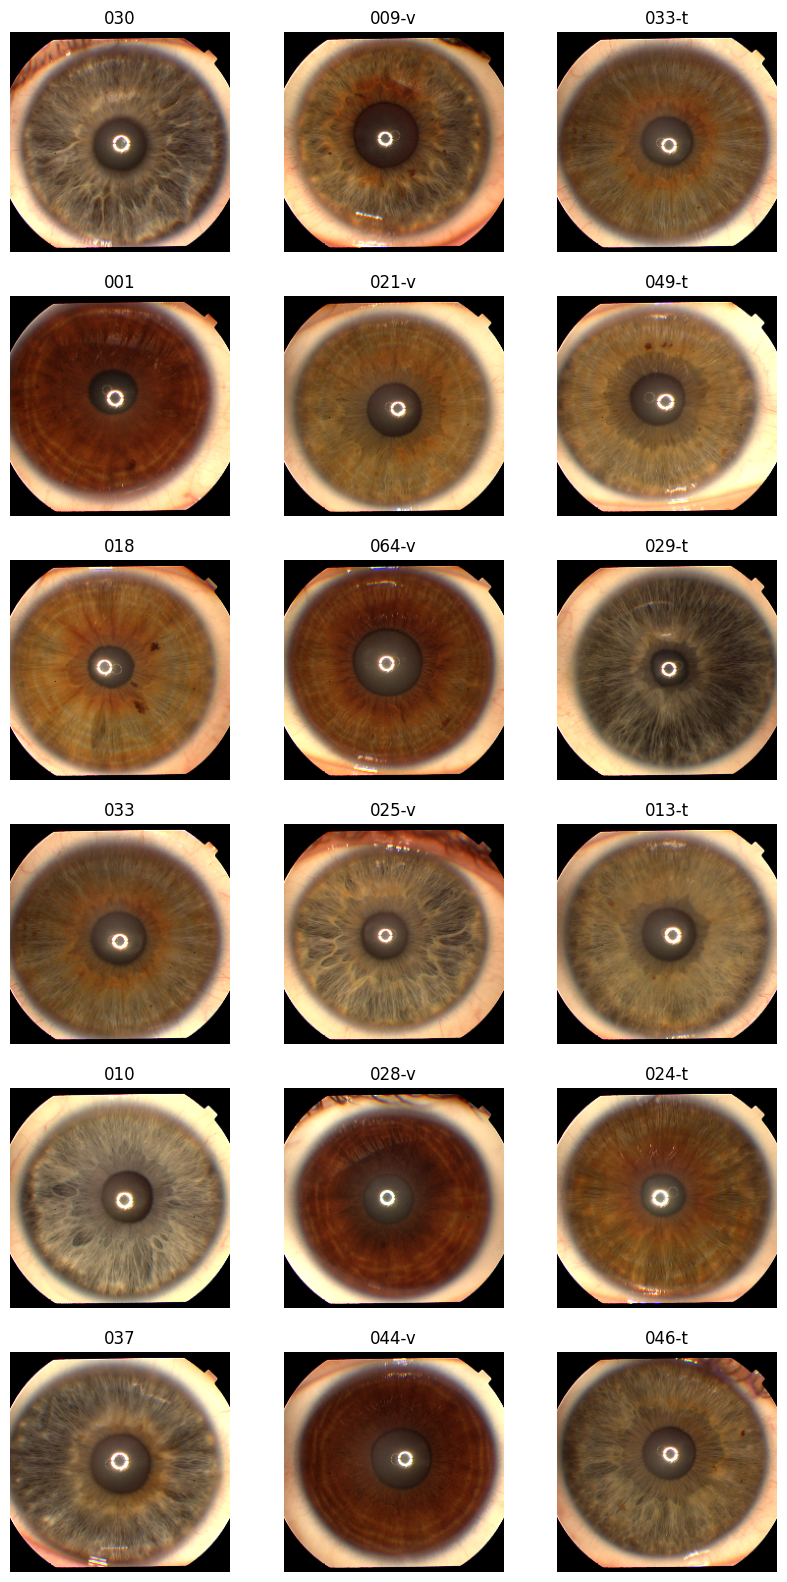

In [14]:
#@title Dataset visualisation
plt.figure(figsize=(10, 20))
for images, labels in train_ds.take(1):
  for images1, labels1 in val_ds.take(1):
    for images2, labels2 in test_ds.take(1):
      for i in range(6):
        ax = plt.subplot(6, 3, i*3 + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        ax = plt.subplot(6, 3, i*3 + 2)
        plt.imshow(images1[i].numpy().astype("uint8"))
        plt.title(class_names[labels1[i]]+"-v")
        plt.axis("off")
        ax = plt.subplot(6, 3, i*3 + 3)
        plt.imshow(images2[i].numpy().astype("uint8"))
        plt.title(class_names[labels2[i]]+"-t")
        plt.axis("off")

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
#@title Layers data_augmentation

data_augmentation = Sequential(
    [
        #layers.RandomFlip("horizontal"),
        # layers.RandomContrast(0.1,
        #                 input_shape=(img_height,
        #                             img_width,
        #                             3)),
        layers.RandomRotation(
            0.1,
            fill_mode='constant',
            fill_value=0.0
        ),
        #  layers.RandomZoom(
        #                   (-0.0, -0.2),
        #                   fill_mode='constant',
        #                   fill_value=0.0,
        #                   )
    ]
)

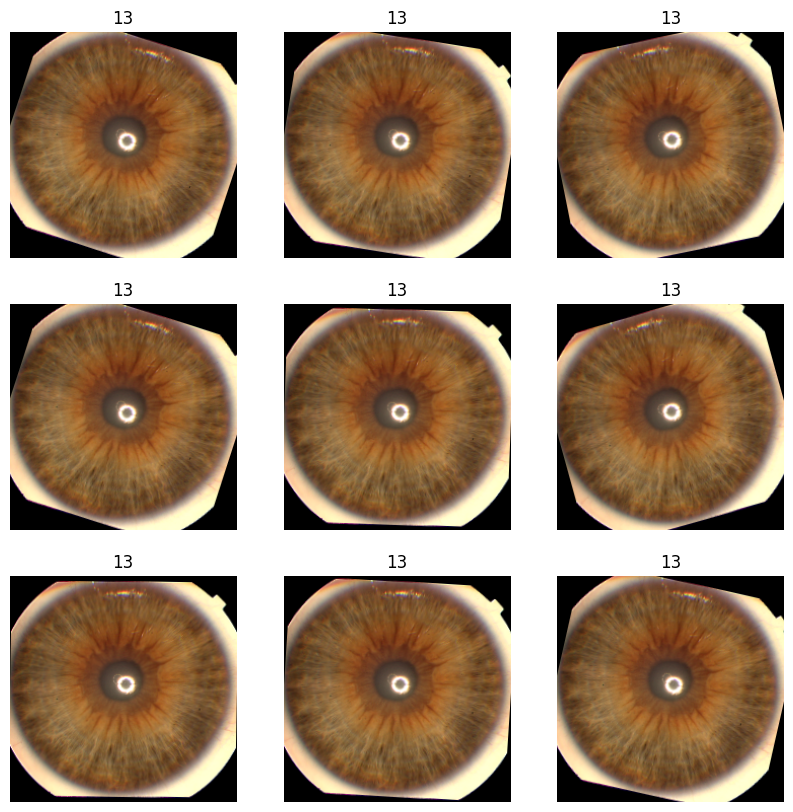

In [17]:
#@title Visualize data_augmentation
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [18]:
#@title Загрузка предобученной модели ResNet50V2 из TensorFlow

# Загрузка весов ResNet50, ResNet50V2 которые были обучены на ImageNet
base_model = ResNet50V2(
    weights='imagenet',
    include_top=False
    #input_shape=(img_width,img_height,3)
)

94668760/94668760 [==============================] - 5s 0us/step


In [19]:
#@title Model creation

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = layers.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)

# Pre-trained weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [22]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [23]:
epochs = 2000
start_time = time.time()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

time_left = (time.time() - start_time)
print("--- %s seconds ---" % time_left)

Epoch 1/2000
8/8 [==============================] - 6s 313ms/step - loss: 1.4522 - accuracy: 0.7403 - val_loss: 1.8997 - val_accuracy: 0.6800
Epoch 2/2000
8/8 [==============================] - 1s 90ms/step - loss: 1.3611 - accuracy: 0.7965 - val_loss: 1.8824 - val_accuracy: 0.6800
Epoch 3/2000
8/8 [==============================] - 1s 90ms/step - loss: 1.3252 - accuracy: 0.8355 - val_loss: 1.8544 - val_accuracy: 0.6800
Epoch 4/2000
8/8 [==============================] - 1s 91ms/step - loss: 1.3395 - accuracy: 0.8268 - val_loss: 1.8165 - val_accuracy: 0.6800
Epoch 5/2000
8/8 [==============================] - 1s 91ms/step - loss: 1.2757 - accuracy: 0.8442 - val_loss: 1.7976 - val_accuracy: 0.6800
Epoch 6/2000
8/8 [==============================] - 1s 98ms/step - loss: 1.2725 - accuracy: 0.8398 - val_loss: 1.7793 - val_accuracy: 0.6400
Epoch 7/2000
8/8 [==============================] - 1s 90ms/step - loss: 1.2728 - accuracy: 0.8139 - val_loss: 1.7627 - val_accuracy: 0.6400
Epoch 8/2000

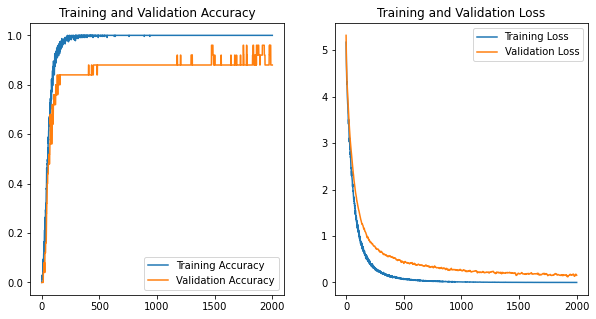

In [ ]:
#@title RESULTS CHARTS
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
#@title RESULTS RATES
loss_tr, acc_tr = model.evaluate(train_ds)
loss_vl, acc_vl = model.evaluate(val_ds)
loss_ts, acc_ts = model.evaluate(test_ds)
print(f'{acc_tr=:5.3f} | {loss_tr=:5.3f}')
print(f'{acc_vl=:5.3f} | {loss_vl=:5.3f}')
print(f'{acc_ts=:5.3f} | {loss_ts=:5.3f} | {batch_size=} | {epochs=} | {img_height=} | {img_width=} | {time_left=:4.0f}')

print(f"{train_path_files=} | {test_path_files=} | {val_split=}")

4/4 [==============================] - 2s 101ms/step - loss: 0.0426 - accuracy: 0.9922
acc_tr=1.000 | loss_tr=0.000
acc_vl=0.880 | loss_vl=0.177
acc_ts=0.992 | loss_ts=0.043 | batch_size=32 | epochs=2000 | img_height=224 | img_width=224 | time_left=1894
train_path_files=256 | test_path_files=128 | val_split=0.1


## Дневник экспериментов

### #01 acc_ts=0.992 | loss_ts=0.043 | val_split=0.1

acc_tr=1.000 | loss_tr=0.000
acc_vl=0.880 | loss_vl=0.177
acc_ts=0.992 | loss_ts=0.043 | batch_size=32 | epochs=2000 | img_height=224 | img_width=224 | time_left=1894
train_path_files=256 | test_path_files=128 | val_split=0.1